# Lookalike Model

In this notebook, we will walk through a step-by-step process to analyze customer data, create profiles, compute similarity scores, and generate recommendations for lookalike customers using Python and several libraries like pandas, scikit-learn, and matplotlib.

### 1.Importing Necessary Libraries
We start by importing the required libraries for data manipulation, machine learning, and visualization.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 2. Loading the Data

In [2]:
# Load the data
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

### 3. Merging Data

In [3]:
# Merge transactions with customer and product data
merged_data = pd.merge(transactions, customers, on='CustomerID', how='left')
merged_data = pd.merge(merged_data, products[['ProductID', 'Price', 'Category']], on='ProductID', how='left')

# Remove duplicate 'Price' columns after merging
merged_data = merged_data.rename(columns={'Price_x': 'TransactionPrice', 'Price_y': 'ProductPrice'})

### 4. Feature Engineering

In this section, we will extract important features for customer and product profiles.


In [4]:
# Customer Profile Features
customer_profile = merged_data.groupby('CustomerID').agg(
    TotalSpend=('TotalValue', 'sum'),
    NumTransactions=('TransactionID', 'count')
).reset_index()

# Product Features
product_features = merged_data.groupby('CustomerID').agg(
    AvgPrice=('ProductPrice', 'mean'),
    ProductCategories=('Category', lambda x: ','.join(x.unique()))
).reset_index()

# Combine Features
customer_profile = pd.merge(customer_profile, product_features, on='CustomerID', how='left')

### 5. Standardizing the Data

We standardize the customer features using StandardScaler to ensure that all features are on the same scale before calculating similarity.

In [5]:
# Standardize the Data
scaler = StandardScaler()
profile_data = customer_profile[['TotalSpend', 'NumTransactions', 'AvgPrice']]
profile_data_scaled = scaler.fit_transform(profile_data)

### 6. Compute Cosine Similarity

Now, we compute the cosine similarity between customers based on their standardized features.

In [6]:
# Compute Cosine Similarity
cosine_sim = cosine_similarity(profile_data_scaled)

### 7. Generate Recommendations

We generate lookalike customer recommendations by finding the top 3 most similar customers for each customer.

In [7]:
lookalike_map = {}
similarity_scores = []  # List to store all similarity scores

for idx, row in customer_profile.iterrows():
    similar_indices = np.argsort(cosine_sim[idx])[::-1][1:4]  # Get top 3 similar customers (exclude self)
    similar_customers = customer_profile.iloc[similar_indices]
    
    # Store the results in the lookalike map
    lookalike_map[row['CustomerID']] = [
        (similar_customers.iloc[i]['CustomerID'], cosine_sim[idx][similar_indices[i]])
        for i in range(3)
    ]
    similarity_scores.extend(cosine_sim[idx][similar_indices])

Here, we loop through each customer and find the top 3 similar customers based on cosine similarity, excluding the customer itself. We then store these lookalike pairs along with their similarity scores.

### 8. Create Lookalike DataFrame

We convert the lookalike recommendations into a DataFrame for easier interpretation and further analysis.

In [8]:
# Create the Lookalike DataFrame
lookalike_list = []
for cust_id, similar_customers in lookalike_map.items():
    for similar_cust_id, score in similar_customers:
        lookalike_list.append([cust_id, similar_cust_id, score])

lookalike_df = pd.DataFrame(lookalike_list, columns=['CustomerID', 'Similar_Customer', 'Similarity_Score'])

# Save to CSV
lookalike_df.to_csv('Abdullathif_Shaik_Lookalike.csv', index=False)

### 9. Evaluation of Similarity Scores

We can evaluate the similarity scores by computing their mean and median.

In [9]:
# Print the mean and median similarity score for evaluation
mean_similarity = np.mean(similarity_scores)
median_similarity = np.median(similarity_scores)

print(f"Mean Similarity Score: {mean_similarity:.4f}")
print(f"Median Similarity Score: {median_similarity:.4f}")

Mean Similarity Score: 0.9869
Median Similarity Score: 0.9947


### 10. Visualization

We visualize the distribution of similarity scores and the customer profiling data.

##### 10.1: Distribution of Similarity Scores
This histogram shows the distribution of the similarity scores.

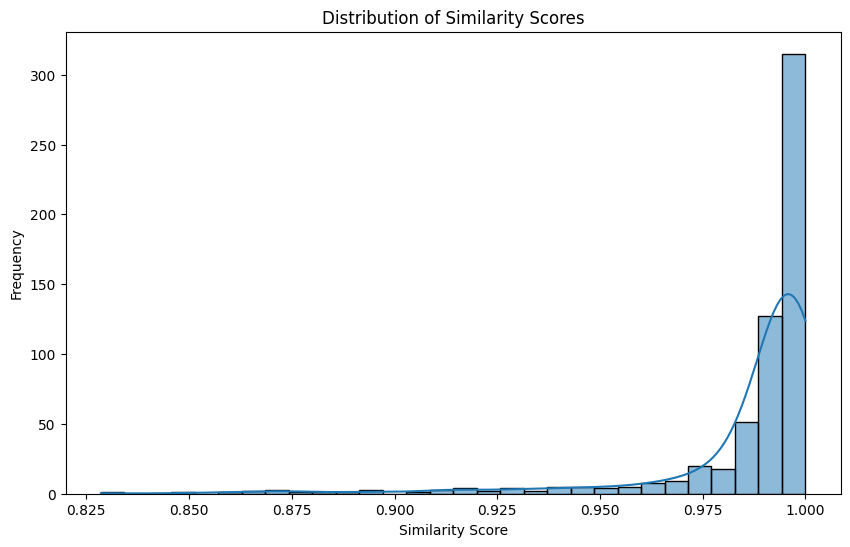

In [10]:
# Visualization
plt.figure(figsize=(10, 6))
sns.histplot(similarity_scores, bins=30, kde=True)
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

### 10.2: Customer Profiling Visualization
This scatter plot visualizes the customer segmentation by total spend and the number of transactions, with colors representing average product prices.

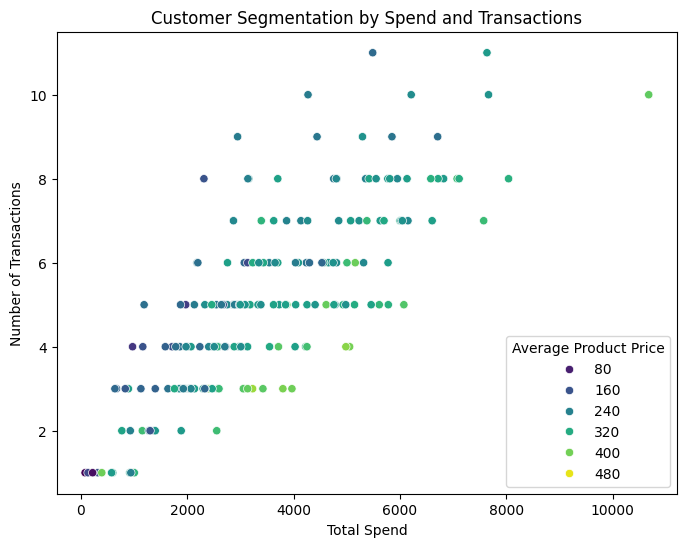

In [11]:
# Scatter plot for customer profiling
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(
    x=customer_profile['TotalSpend'], 
    y=customer_profile['NumTransactions'], 
    hue=customer_profile['AvgPrice'], 
    palette='viridis'
)
plt.title('Customer Segmentation by Spend and Transactions')
plt.xlabel('Total Spend')
plt.ylabel('Number of Transactions')
plt.legend(title='Average Product Price')
plt.show()

Step 11: Final Output

Finally, we check the first few rows of the lookalike_df DataFrame to verify the results.

In [12]:
lookalike_df.head()

,CustomerID,Similar_Customer,Similarity_Score
0,C0001,C0103,0.990942
1,C0001,C0137,0.958920
2,C0001,C0056,0.954716
3,C0002,C0029,0.999852
4,C0002,C0077,0.997599
